In [1]:
# import libraries
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from joblib import dump
from keras import regularizers
from keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing
import matplotlib
from keras.callbacks import EarlyStopping

from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_excel('Data.xlsx')

In [3]:
df1=df

In [4]:
df.index = pd.to_datetime(df['Data'], format='%Y.%m.%d.%H.%M.%S')

In [5]:
df = df.drop('Data',1)

In [6]:
df = df.abs()

In [7]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
Data,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,50.543976,722.154602,999.747437,181.816833,52.821991,34.826756,68.574005,243.284409,6.827167,0.769096,...,9.249084,10.347986,13.644689,57.142857,43.123398,30.432234,28.162088,0.259463,0.161783,0.186203
2018-01-01 01:30:00,50.575138,713.054321,1000.245544,180.946503,52.816032,35.066837,68.521942,241.658829,6.751364,0.767399,...,9.249084,10.073260,13.461538,57.509159,43.282928,30.262323,28.097330,0.259463,0.161783,0.186203
2018-01-01 02:00:00,50.550999,718.224854,1000.586304,181.565201,52.808189,34.919464,68.343872,243.311325,6.586211,0.772498,...,9.294872,10.531136,13.873627,56.776558,43.550549,30.656044,28.484615,0.249084,0.161783,0.175824
2018-01-01 02:30:00,50.587048,726.062012,1000.194885,181.300217,52.778400,34.559654,68.315620,241.139297,6.528387,0.776281,...,9.111722,10.485349,13.919415,57.234432,43.269230,31.227106,28.571428,0.249084,0.161783,0.175824
2018-01-01 03:00:00,50.500458,714.996338,999.772949,179.135620,52.751953,35.018192,68.441750,241.353180,6.676572,0.774640,...,9.432235,10.439561,13.324176,57.600735,43.326283,30.446520,27.793041,0.249084,0.161783,0.175824


In [8]:
df = df['2018-08-01 12:00:00':'2018-10-01 12:00:00'] # Período onde o compressor operou até parar

In [9]:
df_1 = df[['X27','X26','X25','X10']]
df_2 = df[['X14','X9','X18','X15','X19','X17']]
df_3 = df[['X20','X16','X24','X23','X13','X22','X6','X1','X21','X5','X7']]
df_4 = df[['X12','X4','X8']]
df_5 = df[['X2','X3','X11']]


Separando os dados de treino e de teste:
========================================
Este período foi selecionado devido ser onde o compressor operou de forma constante sem falhas

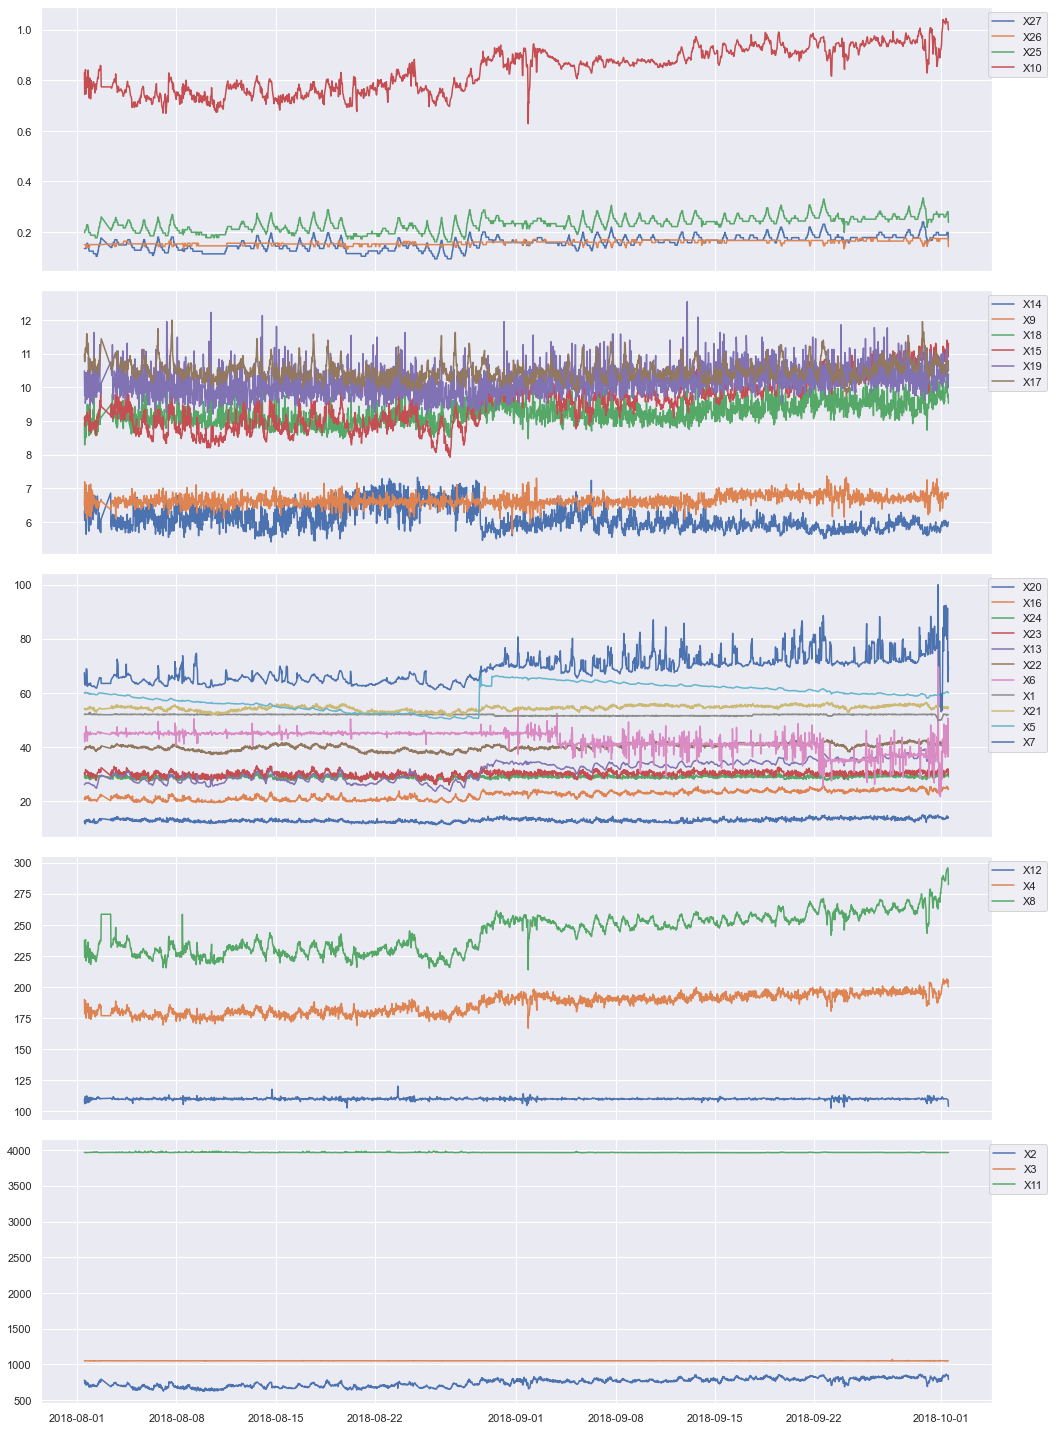

In [10]:
# Plot variables to model

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, sharex=True)
ax1.plot(df_1)
ax1.legend(df_1, loc='upper right', bbox_to_anchor=(0.564, 0.5, 0.5, 0.5))
ax1.grid(True)

ax2.plot(df_2)
ax2.legend(df_2, loc='upper right', bbox_to_anchor=(0.564, 0.5, 0.5, 0.5))
ax2.grid(True)

ax3.plot(df_3)
ax3.legend(df_3, loc='upper right', bbox_to_anchor=(0.564, 0.5, 0.5, 0.5))
ax3.grid(True)

ax4.plot(df_4)
ax4.legend(df_4, loc='upper right', bbox_to_anchor=(0.564, 0.5, 0.5, 0.5))
ax4.grid(True)

ax5.plot(df_5)
ax5.legend(df_5, loc='upper right', bbox_to_anchor=(0.564, 0.5, 0.5, 0.5))
ax5.grid(True)


plt.subplots_adjust(top=5, bottom=0.15, left=0.10, right=2.3, hspace=0.071,wspace=0.2)
plt.show()

In [11]:
train = df['2018-08-01 12:00:00':'2018-09-20 00:00:00'] # Período onde o compressor operou sem problemas
test =  df['2018-09-20 00:00:00':'2018-10-01 12:00:00'] # Período antes da falha

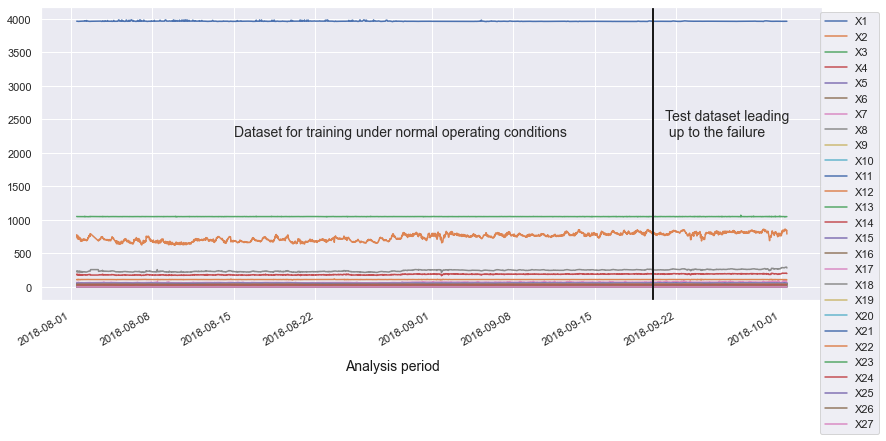

In [12]:
Period = pd.concat([train,test])
ax = Period.plot(figsize = (14,6), legend = None)
plt.axvline('2018-09-20 00:00:00', ymin=-0.01, ymax = 4000, linewidth=2,color = 'k')
plt.legend(loc='upper right', bbox_to_anchor=(0.58, 0.5, 0.5, 0.5))
plt.text('2018-09-21 00:00:00',2250, 'Test dataset leading \n up to the failure',  ha="left", verticalalignment='baseline',fontsize = 14)
plt.text('2018-08-15 00:00:00',2250, 'Dataset for training under normal operating conditions', ha="left", verticalalignment='baseline',fontsize = 14)

ax.set_xlabel('Analysis period', color ='k',fontsize = 14)
ax.xaxis.set_label_coords(0.45, -0.2)

plt.show()


# **Normalizar dados:**

Em seguida, uso as ferramentas de pré-processamento do Scikit-learn para dimensionar as variáveis de entrada do modelo. 
O “MinMaxScaler” simplesmente redimensiona os dados para estar no intervalo [0,1].

In [13]:
# normalize the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
dump(scaler, scaler_filename)

['scaler_data']

In [14]:
# Conversão para float32 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [15]:
# reshape inputs for CNN 
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train_cnn.shape)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("Test data shape:", X_test_cnn.shape)



Training data shape: (2377, 27, 1)
Test data shape: (553, 27, 1)


In [16]:
# Preparar para teste
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), 
                              columns=train.columns, 
                              index=train.index)
# Utilizado Random shuffle nos dados de treinamento para selecionar de forma aleatória
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test), 
                             columns=test.columns, 
                             index=test.index)


In [17]:
# Hiperparâmetros do modelo

# Função de Ativação
ACT_FUNC = 'elu'  

# Dimensões input
INPUT_SHAPE = (X_train.shape[1],1) 

# Tamanho do batch
BATCH_SIZE = 32

# Dropout
DROPOUT_RATE = 0.1

# Número de épocas
EPOCHS = 150

# Seed
seed = 42

SEED = np.random.seed(seed)

# Kernel 
KERNEL = tf.keras.initializers.GlorotUniform(seed=SEED)

# Dados para Split
SPLIT_VAL=0.15

In [18]:
# Arquitetura do Modelo CNN
def anomaly_model(input_shape):
    model = Sequential()
    
      
    # Primeira camada convolucional 
    model.add(Conv1D(128, kernel_size = 7, padding = 'same', kernel_initializer= KERNEL, input_shape = INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Activation(ACT_FUNC))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(DROPOUT_RATE))


    # Segunda camada convolucional 
    model.add(Conv1D(64, kernel_size = 5, padding = 'same', kernel_initializer= KERNEL)) 
    model.add(BatchNormalization()) 
    model.add(Activation(ACT_FUNC))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(DROPOUT_RATE))

    
    # Terceira camada convolucional (encouder)
    model.add(Conv1D(32, kernel_size = 3,  padding = 'same', kernel_initializer= KERNEL))
    model.add(BatchNormalization()) 
    model.add(Activation(ACT_FUNC))

    model.add(Conv1D(32, kernel_size = 3,  padding = 'same', kernel_initializer= KERNEL))
    model.add(BatchNormalization()) 
    model.add(Activation(ACT_FUNC))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(DROPOUT_RATE))
      
  
    # Quarta camada convolucional 
    model.add(Conv1D(64, kernel_size = 5, padding = 'same', kernel_initializer= KERNEL))
    model.add(BatchNormalization()) 
    model.add(Activation(ACT_FUNC))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(DROPOUT_RATE))
   

    # Quinta camada convolucional 
    model.add(Conv1D(128, kernel_size = 7, padding = 'same', kernel_initializer= KERNEL))
    model.add(BatchNormalization()) 
    model.add(Activation(ACT_FUNC))
    model.add(Dropout(DROPOUT_RATE))
    
    model.add(Flatten())

    # Sexta camada totalmente conectada    
    model.add(Dense(100, kernel_initializer= KERNEL , activation = 'relu'))
    model.add(Dropout(DROPOUT_RATE))

    model.add(Dense(X_train.shape[1], activation = "relu", kernel_initializer= KERNEL))
        
    # Otimizador
    model.compile(loss='mse', optimizer='adam')
    return model
    


In [19]:
# Checando a memória da GPU
#!nvidia-smi

Thu Sep 10 08:49:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P5    16W /  N/A |    367MiB /  8192MiB |     31%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [20]:
# Parar recuso da memória da GP
#pid = 23740

In [24]:
#os.kill(pid,pid)

In [25]:
# Controle do modelo
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=6, verbose=1, mode='min')

# fit the model to the data
model = anomaly_model(INPUT_SHAPE)
history = model.fit(X_train_cnn, X_train, epochs=EPOCHS, callbacks= [monitor], batch_size=BATCH_SIZE,
                    validation_split=SPLIT_VAL)

Epoch 1/150
64/64 [==============================] - 1s 14ms/step - loss: 0.1268 - val_loss: 0.2009
Epoch 2/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0547 - val_loss: 0.1083
Epoch 3/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0349 - val_loss: 0.0597
Epoch 4/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0262 - val_loss: 0.0641
Epoch 5/150
64/64 [==============================] - 1s 8ms/step - loss: 0.0215 - val_loss: 0.0493
Epoch 6/150
64/64 [==============================] - 1s 8ms/step - loss: 0.0187 - val_loss: 0.0426
Epoch 7/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 0.0541
Epoch 8/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0153 - val_loss: 0.0336
Epoch 9/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0139 - val_loss: 0.0189
Epoch 10/150
64/64 [==============================] - 1s 9ms/step - loss: 0.0128 - val_loss: 0.0191
Epoch 11

In [ ]:
# model.summary()

In [ ]:
# save all model information, including weights, in h5 format
model.save("Anomaly_model.h5",include_optimizer=True)


print("Model saved")

(0.0, 0.3)

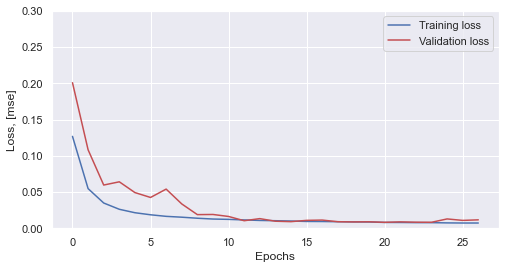

In [26]:
plt.figure(figsize = (8,4))
plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.3])


In [27]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Anomaly_model.h5')

(0.0, 0.16)

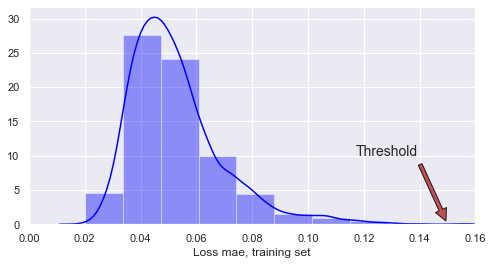

In [28]:
plt.figure(figsize = (8,4))
X_pred = model.predict(np.array(X_train_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.annotate('Threshold',fontsize = 14, xy=(0.15 , 0), xytext=(0.117, 10),
            arrowprops=dict(facecolor='black', shrink=0.05, color = 'r',ec ='k'))

sns.set(font_scale=1.2)
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             axlabel ="Loss mae, training set",
             kde= True,
             color = 'blue');

  
plt.xlim([0.0,.16])



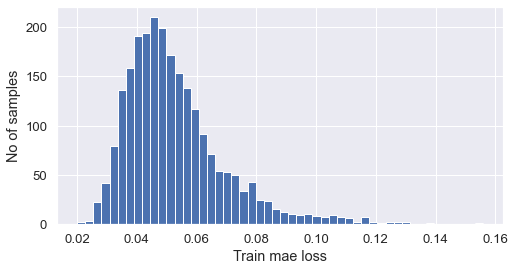

Reconstruction error threshold:  0.156


In [29]:
# Get train MAE loss.
plt.figure(figsize = (8,4))
plt.hist(scored['Loss_mae'], bins=50)
plt.xlabel("Train mae loss")
plt.ylabel("No of samples")
plt.show()

 
# Get reconstruction loss threshold.
threshold = np.round(np.max(scored['Loss_mae']),3)
print("Reconstruction error threshold: ", threshold)

(0.0, 0.2)

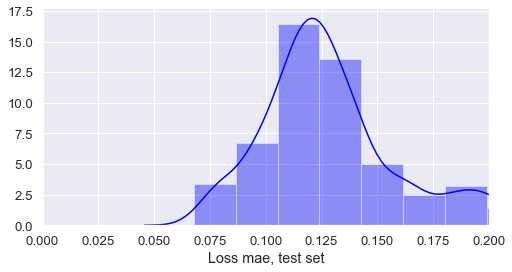

In [30]:
X_pred = model.predict(np.array(X_test_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

sns.set(font_scale=1.2) 
plt.figure(figsize = (8,4))
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             axlabel ="Loss mae, test set", 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.2])

In [31]:
X_pred_train = model.predict(np.array(X_train_cnn))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [32]:
scored_train.head()

,Loss_mae,Threshold,Anomaly
Data,,,
2018-08-01 12:00:00.002,0.081529,0.156,False
2018-08-01 12:30:00.002,0.086597,0.156,False
2018-08-01 13:00:00.002,0.055760,0.156,False
2018-08-01 13:30:00.002,0.090722,0.156,False
2018-08-01 14:00:00.002,0.084076,0.156,False


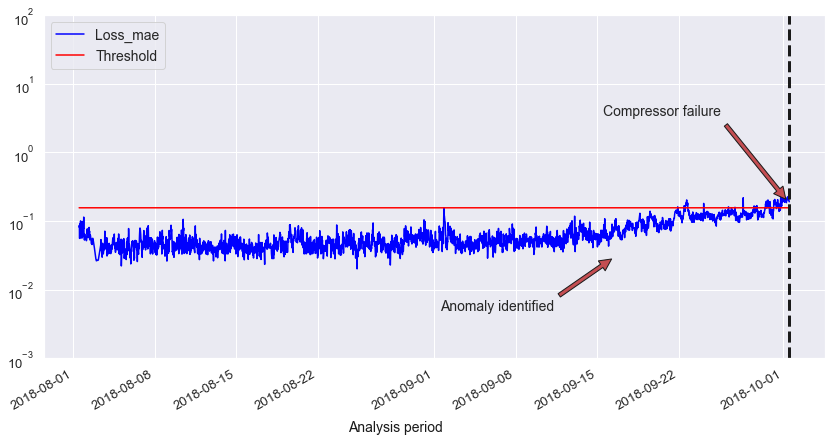

In [33]:
ax = scored.plot(logy=True,  figsize = (14,7), ylim = [1e-3,1e2],  color = ['blue','red'])
ax.annotate('Anomaly identified',fontsize = 14, xy=('2018-09-16 12:00:00', 0.03), xytext=('2018-09-01 11:00:00', 0.005),
            arrowprops=dict(facecolor='black', shrink=0.05, color = 'r', ec ='k'))

ax.annotate('Compressor failure',fontsize = 14, xy=('2018-10-01 12:00:00', 0.18), xytext=('2018-09-15 11:00:00', 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05, color = 'r',ec ='k'))

plt.legend(loc='upper left', fontsize = 14)
plt.axvline('2018-10-01 11:00:00', linewidth = 3, color = 'k', linestyle = "--")


ax.set_xlabel('Analysis period', color ='k',fontsize = 14)
ax.xaxis.set_label_coords(0.45, -0.18)

plt.show()

In [34]:

df_TraTes = pd.concat([X_train,X_test])

In [179]:
# Realizando o Subset do resultado 
df0 = pd.DataFrame(scored.Loss_mae)

In [507]:
# Agrupando o resultado dos Scores
df_fim = pd.merge(df_TraTes,df0, on=["Data"])
df_fim = df_fim.dropna()

# Stationarity Test

In [508]:
ts = df_fim['Loss_mae']

In [509]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=48).mean()
    rolstd = pd.Series(timeseries).rolling(window=48).std()
    #Plot rolling statistics:
    plt.figure(figsize = (14,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    array = np.asarray(timeseries, dtype='float')
    np.nan_to_num(array,copy=False)
    dftest = adfuller(array, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

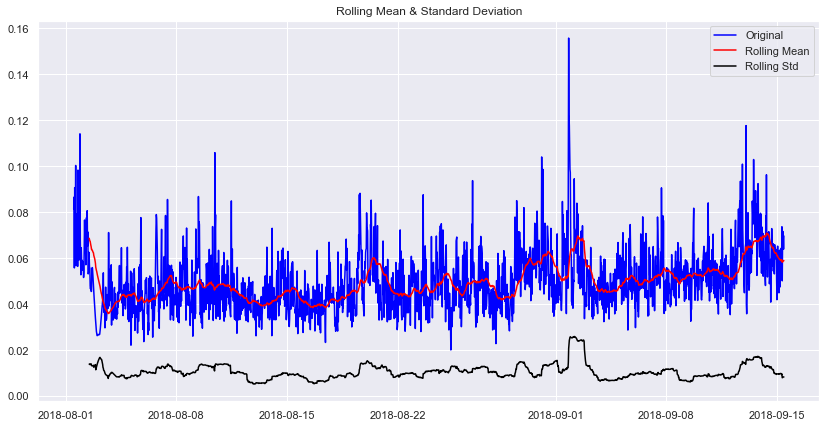

Results of Dickey-Fuller Test:
Test Statistic                -5.757356e+00
p-value                        5.778260e-07
#Lags Used                     1.700000e+01
Number of Observations Used    2.141000e+03
Critical Value (1%)           -3.433408e+00
Critical Value (5%)           -2.862891e+00
Critical Value (10%)          -2.567489e+00
dtype: float64


In [510]:
ts = ts['2018-08-01 12:00:00':'2018-09-15 11:00:00']
test_stationarity(ts)

In [511]:
df_fim = df_fim['2018-09-15 11:00:00':'2018-10-01 12:00:00'] # Período onde o compressor operou até parar



<span style="color:red">FEATURE IMPORTANCE</span>
=============================

In [513]:
y = df_fim.iloc[:,-1]
X = df_fim.iloc[:,0:27]

In [514]:
# visualisations
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(30, 25)})

In [515]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [526]:
np.random.seed(seed = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [527]:

rf = RandomForestRegressor(n_estimators = 150,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True,
                      random_state=42)

In [528]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

R^2 Training Score: 0.99 
OOB Score: 0.90 
R^2 Validation Score: 0.90


In [529]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
#base_imp

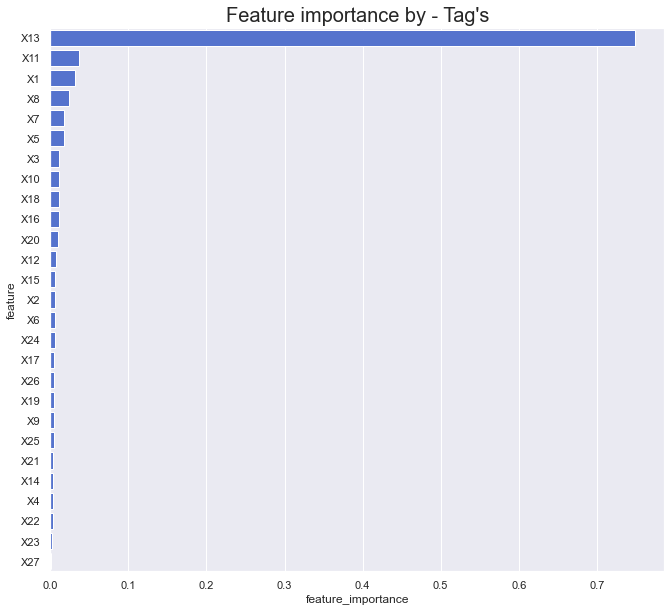

In [530]:
plt.rcParams['figure.figsize'] = [11, 10]
var_imp_plot(base_imp, "Feature importance by - Tag's")

In [463]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True) #False

In [ ]:
plt.rcParams['figure.figsize'] = [11, 10]
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

In [ ]:
# https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 100).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance Random Forest')

In [ ]:
xgb = XGBRegressor(n_estimators=150,
                           booster='gbtree',
                           importance_type='gain',
                           gpu_id=-1,
                           verbosity=1,
                           random_state = 42)
xgb.fit(X_train, y_train)

In [ ]:
print('R^2 Training Score: {:.2f}  \nR^2 Validation Score: {:.2f}'.format(xgb.score(X_train, y_train), 
                                                                          xgb.score(X_valid, y_valid)))                        
                                                                                             

In [ ]:
base_imp_xgb = imp_df(X_train.columns, xgb.feature_importances_)
base_imp_xgb

In [ ]:
plt.rcParams['figure.figsize'] = [11, 10]
var_imp_plot(base_imp_xgb, "Feature importance by - Tag's - xgboost")

In [ ]:
perm_xgb = PermutationImportance(xgb,  cv = None, refit = False, n_iter = 150).fit(X_train, y_train)
perm_imp_eli5_xgb = imp_df(X_train.columns, perm_xgb.feature_importances_)
var_imp_plot(perm_imp_eli5_xgb, 'Permutation feature importance xgboost ')